In [1]:
from sklearn.model_selection import train_test_split

from transformers import T5Tokenizer, T5ForConditionalGeneration  

from transformers import AdamW
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn.utils.rnn import pad_sequence


Here **PyTorch-lightning** is used: PyTorch Lightning is a lightweight interface for PyTorch that simplifies the process of training deep learning models. It provides pre-built components and features for common tasks, making the code more modular and reusable. PyTorch Lightning also provides various features such as automatic checkpointing, distributed training, and multi-GPU training. It follows a strict design pattern and provides hooks and callbacks for customization. It is compatible with various hardware platforms such as CPUs and GPUs.

In [2]:
data = pd.read_csv("/kaggle/input/3k-conversations-dataset-for-chatbot/Conversation.csv")
data.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
print("No of rows:" ,data.shape[0])

No of rows: 3725


In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_MAX_LEN = 128 #input length
OUTPUT_MAX_LEN = 128 # output length
TRAIN_BATCH_SIZE = 8 # batch size of training
VAL_BATCH_SIZE = 2 # batch size for validation
EPOCHS = 5 # number of epoch

# T5 Tokenizer

In [7]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512)


Example of how T5 Tokenizer actually work.

In [9]:
text = "Hello, how are you today?"    # assume the text that is to be tokenized 

input_tokenize = tokenizer( 
             text,
            add_special_tokens=True,        #Add Special tokens like [CLS] and [SEP]
            max_length=128,
            padding = 'max_length',         #for padding to max_length for equal sequence length
            truncation = True,              #truncate the text if it is greater than max_length
            return_attention_mask=True,     #will return attention mask
            return_tensors="pt"             #return tensor formate
        )

In [10]:
print("input_ids: ", input_tokenize['input_ids'].flatten())
print("Attention Mask: ", input_tokenize['attention_mask'].flatten())

input_ids:  tensor([8774,    6,  149,   33,   25,  469,   58,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Attention Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
class T5Dataset:
    
  def __init__(self,question,answer):   
    
    self.question = question
    self.answer = answer
    self.tokenizer = tokenizer
    self.input_max_len = INPUT_MAX_LEN
    self.output_max_len = OUTPUT_MAX_LEN
  
  def __len__(self):                      # This method retrives the number of item from the dataset
    return len(self.question)

  def __getitem__(self,item):             # This method retrieves the item at the specified index item. 

    question = str(self.question[item])
    question = ''.join(question.split())

    answer = str(self.answer[item])
    answer = ''.join(answer.split())

    input_tokenize = self.tokenizer(      
            question,
            add_special_tokens=True,
            max_length=self.input_max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"
        )
    output_tokenize = self.tokenizer(
            answer,
            add_special_tokens=True,
            max_length=self.output_max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"
            
        )
    

    input_ids = input_tokenize["input_ids"].flatten()
    attention_mask = input_tokenize["attention_mask"].flatten()
    labels = output_tokenize['input_ids'].flatten()

    out = {
            'question':question,      
            'answer':answer,
            'input_ids': input_ids,
            'attention_mask':attention_mask,
            'target':labels
        }
        
    return out      

# Data Loader


In [12]:
class T5DataLoad(pl.LightningDataModule):
    
    def __init__(self,df_train,df_test):
        super().__init__()
        self.df_train = df_train
        self.df_test = df_test
        self.tokenizer = tokenizer
        self.input_max_len = INPUT_MAX_LEN
        self.out_max_len = OUTPUT_MAX_LEN
    
    def setup(self, stage=None):
        
        self.train_data = T5Dataset(
            question = self.df_train.question.values,
            answer = self.df_train.answer.values
        )
        
        self.valid_data = T5Dataset(
            question = self.df_test.question.values,
            answer = self.df_test.answer.values
        )
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
         self.train_data,
         batch_size= TRAIN_BATCH_SIZE,
         shuffle=True, 
         num_workers=2
        )
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
        self.valid_data,
        batch_size= VAL_BATCH_SIZE,
        num_workers = 2
        )

# Building T5 Model

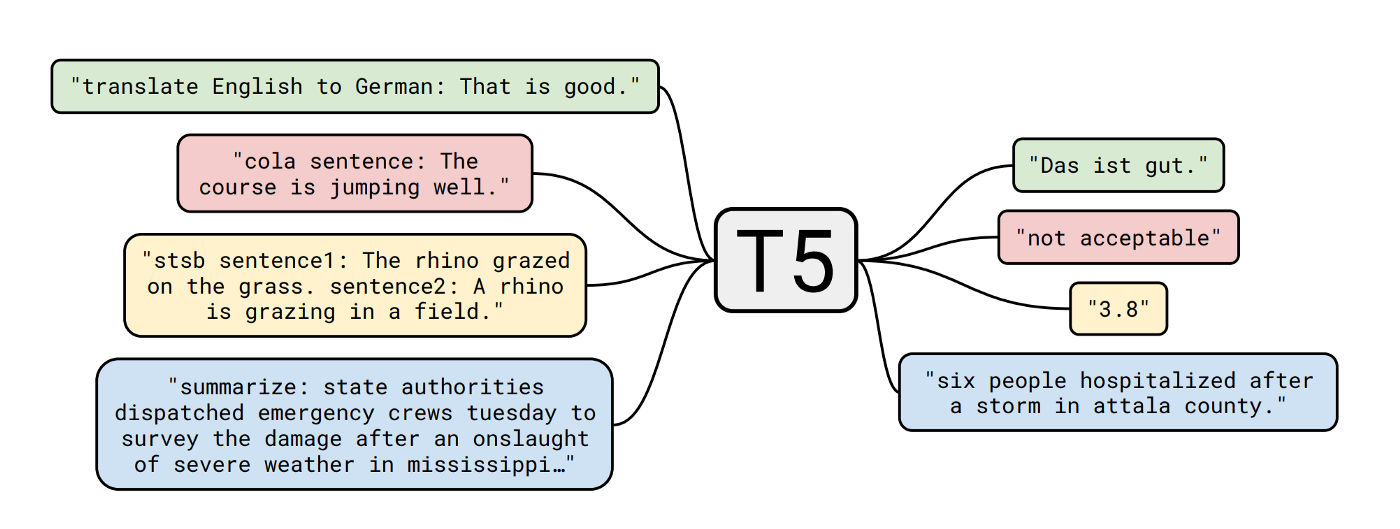

In [13]:
class T5Model(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)

        
    def forward(self, input_ids, attention_mask, labels=None):
        
        output = self.model(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        labels=labels
        )
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids , attention_mask, labels)

        
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids, attention_mask, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {'val_loss': loss}

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

# Final Training Step

In [14]:
def run():
    df_train, df_test = train_test_split(data,test_size = 0.2, random_state=100)
    dataload = T5DataLoad(df_train,df_test)
    dataload.setup()
    device = DEVICE
    model = T5Model()
    model.to(device)
    
    checkpoint = ModelCheckpoint(
        dirpath="/kaggle/working",
        filename='best-model',
        save_top_k=2,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )
    trainer = pl.Trainer(
        callbacks = checkpoint,
        max_epochs= 1,
        gpus=1,
        accelerator="gpu"
    )
    trainer.fit(model, dataload)
run()

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:475: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
train_model = T5Model.load_from_checkpoint('/kaggle/working/best-model.ckpt')
train_model.freeze()

def generate_question(question):

    inputs_encoding =  tokenizer(
        question,
        add_special_tokens=True,
        max_length= INPUT_MAX_LEN,
        padding = 'max_length',
        truncation='only_first',
        return_attention_mask=True,
        return_tensors="pt"
        )

    
    generate_ids = train_model.model.generate(
        input_ids = inputs_encoding["input_ids"],
        attention_mask = inputs_encoding["attention_mask"],
        max_length = INPUT_MAX_LEN,
        num_beams = 4,
        num_return_sequences = 1,
        no_repeat_ngram_size=2,
        early_stopping=True,
        )

    preds = [
        tokenizer.decode(gen_id,
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True)
        for gen_id in generate_ids
    ]

    return "".join(preds)


# Model Evaluation

In [16]:
ques = "hi, how are you doing?"
print("Ques: ",ques)
print("BOT: ",generate_question(ques))

Ques:  hi, how are you doing?
BOT:  hi, how are you doing?


In [17]:
ques = "how's it going?"
print("Ques: ",ques)
print("BOT: ",generate_question(ques))

Ques:  how's it going?
BOT:  how's it going?
